<a id="contents"></a>

# Notebook Contents

- [1. Data Cleaning](#id1)
    - [1.1 Clean the data for the seasons 2018-2020](#id1.1)
    - [1.2 Clean the data for the seasons 2010-2017](#id1.2)
    - [1.3 Helper function for reading the data](#id1.3)
- [2. World Football Elo Ratings](#id2)
    - [2.1 The System](#id2.1)
    - [2.2 The code for the system](#id2.2)
    - [2.3 Training on the first five seasons](#id2.3)
    - [2.4 Recording for the next five seasons](#id2.4)
- [3. Hypothesis Testing](#id3)
    - [3.1 Performing a t-test](#id3.1)
    - [3.2 Performing a permutation test](#id3.2)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from tqdm import tqdm


<a id="id1"></a>

# Part 1: Data Cleaning

[Return to contents](#contents)

The UCL and Europa League data are collected from different websites. This section reads the data and saves it in a format consistant with the rest of the data. 

Many team names are not consistent through all of the data. So, it is hard to go through each one and fix it. However, we manuallly checked the names of all the teams that played against Real Madrid in the knockout stages of the UCL between 2016 and 2020, as these are the games with highest stakes for this project. 

<a id="id1.1"></a>

## 1.1 Clean the data for the seasons 2018-2020
[Return to contents](#contents)

Only run those once if you only have the raw data

In [2]:
# Fix some team names

def fix_team_names(s):
    # Nans:
    if type(s) != str:
        return s
    name_fixer = {
        'FC Barcelona':'Barcelona',
        'Paris Saint-Germain':'Paris SG',
        'Bayern Munchen':'Bayern Munich',
        'Manchester United':'Man United',
        'Manchester Utd':'Man United',
        'Manchester City':'Man City',
        'Atletico Madrid':"Ath Madrid",
        'Atlético Madrid':"Ath Madrid",
        'VfL Wolfsburg':"Wolfsburg",
        'AS Roma':'Roma',
        'FC Porto': 'Porto',
        'FC Basel':'Basel' 
    }
    if s in name_fixer.keys():
        return name_fixer[s]
    return s

In [3]:
clean = False
if clean:
    for year in ['2018', '2019', '2020']:
        for competition in ['ucl', 'europa']:
            df = pd.read_csv(f'data/raw/{year} {competition}.csv')

            # Home team
            def remove_suffix(s):
                if type(s) != str:
                    return s
                lst = s.split()
                new_string = ' '.join(lst[0:-1])
                new_string = new_string.replace('-', '')
                return new_string
            df['HomeTeam'] = df['Home'].apply(remove_suffix)

            # Away team
            def remove_prefix(s):
                if type(s) != str:
                    return s
                lst = s.split()
                new_string = ' '.join(lst[1:])
                new_string = new_string.replace('-', '')
                return new_string
            df['AwayTeam'] = df['Away'].apply(remove_prefix)
            
            # Fix some team names
            df['HomeTeam'] = df['HomeTeam'].apply(fix_team_names)
            df['AwayTeam'] = df['AwayTeam'].apply(fix_team_names)

            # Scores
            def get_score(s, is_home):
                # is_home = is_home_tuple[0]
                if type(s)!=str:
                    return s
                lst = s.split('–')
                if is_home:
                    return int(lst[0])
                else:
                    return int(lst[1])
            df['FTHG'] = df['Score'].apply(get_score, args = [True])
            df['FTAG'] = df['Score'].apply(get_score, args = [False])
            df['is_group_stage'] = df['Round']=='Group stage'
            df = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'is_group_stage']]
            df.to_csv(f'data/{competition}/{year}.csv', index = False)

<a id="id1.2"></a>

## 1.2 Clean the data for the seasons 2010-2017

[Return to contents](#contents)

In [4]:
if clean:
    years = [x for x in range(2011, 2018)]
    df = pd.read_csv('data/raw/euroties_WithCountries.csv')
    for year in years:
        for competition, competition_name in zip(['ucl', 'europa'], ['CHAMPIONS LEAGUE', 'EUROPA LEAGUE']):
            # select season and competition
            cur_df = df.loc[(df['Season'] == year) & (df['Competition Name'] == competition_name)].copy()

            # Change column names HomeGoals	AwayGoals
            cur_df['FTHG'] = cur_df['HomeGoals']
            cur_df['FTAG'] = cur_df['AwayGoals']

            cur_df['HomeTeam'] = cur_df['HomeTeam'].apply(fix_team_names)
            cur_df['AwayTeam'] = cur_df['AwayTeam'].apply(fix_team_names)

            # check if in group or qualifying stage
            def is_group_stage(s):
                if 'Qualifying' in s or 'Group' in s:
                    return True
                return False
            cur_df['is_group_stage'] = cur_df['Stage'].apply(is_group_stage)
            cur_df = cur_df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'is_group_stage']]
            cur_df.to_csv(f'data/{competition}/{str(year)}.csv', index = False)

<a id="id1.3"></a>

## 1.3 Helper function for reading the data

[Return to contents](#contents)


In [5]:
leagues = ['england', 'france', 'germany', 'italy', 'netherlands', 'portugal', 'spain', 'ucl', 'europa']

In [6]:
def read_data(competition, year):
    """
        year (int): a year between 0 (2010-2011) and 9 (2019-2020)
        competition (string): one of the top 7 leagues or ucl
    """
    year_dir = os.listdir(f'data/{competition}')[year]
    df = pd.read_csv(f'data/{competition}/{year_dir}')
    if competition in leagues[:-2]:
        df = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    else:
        df = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'is_group_stage']]
    df = df.dropna()
    return df

<a id="id2"></a>

# Part 2: World Football Elo Ratings

[Return to contents](#contents)


<a id="id2.1"></a>

## 2.1 The System

[Return to contents](#contents)

The parameters for this system are based on the World Football Elo Ratings.

The system is as follows:

After each match, we updating the rating:

$
R_n = R_0 + K ( W - W_e)
$

Where $R_n$ is the new rating, $R_0$ is the old rating.

$K$ is the weight of the competition. It is $50$ for European competitions, and $30$ for local leagues. $K$ is then adjusted for the goal difference in the game. It is increased by a factor of half if a game is won by two goals, by $3/4$ if a game is won by three goals, and by $3/4 + (N-3)/8$ if the game is won by four or more goals, where $N$ is the goal difference.

$W$ is the result of the match, $1$ for a win, $1/2$ for a draw, and $0$ for a loss.

$W_e$ is the expected result (win expectancy). It is calculated using the formula:

$$
W_e = \frac{1}{1+10^{-dr/400}}
$$

Where $dr$ is the difference in rating before the match starts, and we add $100$ to it for the home team. 

Check http://eloratings.net/about for the more details.



<a id="id2.2"></a>

## 2.2 The code for the system

[Return to contents](#contents)

In [7]:
class ELO_WFER():
    # Elo system based on http://eloratings.net/about
    
    def __init__(self):
        # Parameters
        self.initial_strength = 1500
        self.k_ucl = 50
        self.k_other = 30
        
        # Strengths
        self.full_strengths = {}
        self.league_strengths = {}
        
        self.leagues = ['england', 'france', 'germany', 'italy', 'netherlands', 'portugal', 'spain', 'ucl', 'europa']
        
        # Initial strengths
        for league in self.leagues:
            df = read_data(league, 0)
            teams = df.HomeTeam.unique()
            cur_strengths = {}
            for team in teams:
                cur_strengths[team.strip()] = self.initial_strength
            self.league_strengths[league] = cur_strengths
            self.full_strengths.update(cur_strengths)
        return 
    
    def get_team_strength(self, team, competition, year):
        """
            Given a team, return its strength.
            If this is a new team promoted to this competition, return the mean
            of all the teams that were relegated from this competition. This is
            a good initial rating for the new team. 
        """
        cur_strengths = self.league_strengths[competition]
        # Check if we already have a strength:
        if team in cur_strengths.keys():
            return cur_strengths[team]
        if team in self.full_strengths.keys():
            return self.full_strengths[team]
        
        # Find all the teams that were relegated from this competition
        df = read_data(competition, year)
        teams_this_year = df.HomeTeam.unique()
        missing_teams = [x for x in cur_strengths.keys() if x not in teams_this_year]
        # Find their strengths
        missing_strengths = [cur_strengths[x] for x in missing_teams]
        # Return the mean
        return np.mean(missing_strengths)
    
    def update_team_strength(self, team, competition, new_strength):
        """
            Given a team and its new strength, update the strength dictionaries
            with this new value. 
        """
        self.full_strengths[team] = new_strength
        self.league_strengths[competition][team] = new_strength
        for league in self.leagues:
            if team in self.league_strengths[league].keys():
                self.league_strengths[league][team] = new_strength
        return
    
    @staticmethod
    def get_expected_result(home_strength, away_strength, on_home_stadium = 1):
        """
            Given the home and away strengths, and whether the game is on the home stadium
            or on a neutral stadium, return the probability of the home team winning. 
        """
        strength_difference = home_strength - away_strength + 100 * on_home_stadium
        expected_result = 1 / ((10 ** (-strength_difference/400)) + 1)
        return expected_result
        
    
    def update_one_match(self, row, competition, year, on_home_stadium = 1):
        """
            Given the data for one match in 'row', update the ratings of the teams involved
            based on this match. 
            Returns the difference between the expected and actual result of this match. 
        """
        # Get the data
        cur_strengths = self.league_strengths[competition]
        home_team = row['HomeTeam'].strip()
        away_team = row['AwayTeam'].strip()
        home_goals = row['FTHG']
        away_goals = row['FTAG']
        home_strength = self.get_team_strength(home_team, competition, year)
        away_strength = self.get_team_strength(away_team, competition, year)
        
        # Get the k
        if competition == 'ucl' or competition == 'europa':
            k = self.k_ucl
        else:
            k = self.k_other
        
        # Adjust k based on goal difference
        goal_difference = abs(home_goals - away_goals)
        if goal_difference > 3.5:
            k += (3 / 4 + (goal_difference - 3) / 8) * k
        elif goal_difference > 2.5:
            k += (3 / 4) * k
        elif goal_difference > 1.5:
            k += (1 / 2) * k
        
        # Apply the model
        expected_result = self.get_expected_result(home_strength, away_strength, on_home_stadium)
        if home_goals > away_goals:
            actual_result = 1
        elif home_goals < away_goals:
            actual_result = 0
        else:
            actual_result = 0.5
        result_difference = actual_result - expected_result
        
        # New Ratings
        home_strength = home_strength + k * result_difference
        away_strength = away_strength - k * result_difference
        
        # Update the ratings
        self.update_team_strength(home_team, competition, home_strength)
        self.update_team_strength(away_team, competition, away_strength)
        
        return result_difference

<a id="id2.3"></a>
## 2.3 Training on the first five seasons

[Return to contents](#contents)

In [8]:
elo = ELO_WFER()

In [9]:
# Train
for year in tqdm(range(5)):
    for league in leagues:
        df = read_data(league, year)
        for index, row in df.iterrows():
            x = elo.update_one_match(row, league, year)

100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


#### Checking the top teams:

Let's look at the teams with the top ten ratings. This is both an interesting result and a sanity check that our ratings makes sense.

In [10]:
top_teams = [(k, v) for k, v in sorted(elo.full_strengths.items(), key=lambda item: item[1])][-10:]

In [11]:
top_teams.reverse()

In [12]:
display(top_teams)

[('Barcelona', 2088.451969067935),
 ('Bayern Munich', 1977.4582780346184),
 ('Real Madrid', 1971.3515207182147),
 ('Sevilla', 1942.3549397338927),
 ('Juventus', 1905.7750728997642),
 ('Porto', 1883.180242009943),
 ('Chelsea', 1874.619914925156),
 ('Ath Madrid', 1848.0326823549387),
 ('Paris SG', 1828.8409704442029),
 ('Arsenal', 1817.0029819527754)]

We can see that Barcelona is the team with top rating, which makes sense at the end of the 2015 season, as they had won the treple that year. We also see some other top teams, such as Bayern Munich, Real Madrid, and Juventus. We also see that Sevilla and Porto are in the top ten. While this doesn't seem very accurate, we note that Sevilla won the 2014-2015 Europa League and Porto made it to the top 8 in the Champions league that year, which can explain these results. 

<a id="id2.4"></a>

## 2.4 Recording for the next five seasons

[Return to contents](#contents)

When working with these seasons, we still update the elo ratings with the match results, but we also record the difference between the expected outcome and the actual outcome for each match. We only record these for some teams, including Real Madrid. We also separately record the matches of the knockout stages of the UEFA Champions League and UEFA Europe League, and the rest of the matches. 

In [13]:
vip_team = 'Real Madrid'
max_rating = elo.full_strengths[vip_team]
league_changes = []
ucl_changes = []

In [14]:
for year in tqdm(range(5,10)):
    for league in leagues:
        df = read_data(league, year)
        for index, row in df.iterrows():
            # Update
            x = elo.update_one_match(row, league, year)
            
            # Track
            if row['HomeTeam'] == vip_team:
                if league == 'ucl' and not row['is_group_stage']:
                    ucl_changes.append(x)
                else:
                    league_changes.append(x)
                max_rating = max(max_rating, elo.full_strengths[vip_team])
            if row['AwayTeam'] == vip_team:
                if league == 'ucl' and not row['is_group_stage']:
                    ucl_changes.append(-x)
                else:
                    league_changes.append(-x)
                max_rating = max(max_rating, elo.full_strengths[vip_team])

100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


In [15]:
print(f"The number of matches recorded in UCL knockout stages for Real Madrid is {len(ucl_changes)}")
print(f"The number of other matches recorded Real Madrid is {len(league_changes)}")

The number of matches recorded in UCL knockout stages for Real Madrid is 25
The number of other matches recorded Real Madrid is 220


In [16]:
print(f"The top rating for Real Madrid during the last five seasons was {max_rating:0.2f}")

The top rating for Real Madrid during the last five seasons was 2133.71


In [17]:
mean_difference = np.mean(ucl_changes) - np.mean(league_changes)
print(f"The mean of changes for the UCL knockouts is {np.mean(ucl_changes):0.3f}")
print(f"The mean of changes for the other matches is {np.mean(league_changes):0.3f}")
print(f"The difference between those two is {mean_difference:0.3f}")

The mean of changes for the UCL knockouts is 0.083
The mean of changes for the other matches is -0.061
The difference between those two is 0.144


#### Checking the Top Teams:

We check the top ten teams again for sanity checking. 

In [18]:
top_teams = [(k, v) for k, v in sorted(elo.full_strengths.items(), key=lambda item: item[1])][-10:]

In [19]:
top_teams.reverse()

In [20]:
display(top_teams)

[('Bayern Munich', 2110.451258615722),
 ('Paris SG', 1959.795875078668),
 ('Man City', 1904.671213191514),
 ('Liverpool', 1894.3744163110498),
 ('Barcelona', 1888.4292978313865),
 ('Borussia Dortmund', 1850.1283663925271),
 ('Inter', 1843.3798367645627),
 ('Sevilla', 1839.7569707191803),
 ('Real Madrid', 1829.146144565307),
 ('Ath Madrid', 1827.137740891309)]

<a id="id3"></a>
# Part 3: Hypothesis Testing

[Return to contents](#contents)

Now we have two sets of samples, the differences in the matches of La Liga, stored in `league_changes`, and the differences in the matches of UCL, stored in `ucl_changes`. We hypothsis that these two sets come from the same distribution and perform a one sided hypothsis test to prove that our assumption is wrong. If it turns out that the hypothsis is wrong, we can say that it is very unlikely that Real Madrid won the three UCL by simple luck or randominess. 

<a id="id3.1"></a>
## 3.1 Performing a t-test

[Return to contents](#contents)

Here, we perform a t-test on the two distributions.

In [21]:
# Print the mean of each list
print(f"The mean of the difference between expectation and reality for the UCL matches is {np.mean(ucl_changes):0.3f}")
print(f"The mean of the difference between expectation and reality for the other matches is {np.mean(league_changes):0.3f}")

The mean of the difference between expectation and reality for the UCL matches is 0.083
The mean of the difference between expectation and reality for the other matches is -0.061


In [22]:
p = stats.ttest_ind(ucl_changes, league_changes, alternative = 'greater')[1]
print(f"The p-value for the t-test is {p:0.4f}")

The p-value for the t-test is 0.0323


We can see that the test gives a p-value of $0.0323$. 

<a id="id3.2"></a>
## 3.2 Performing a permutation test


[Return to contents](#contents)

While the t-test shows a significant difference, we are worried that the p-value is very close to $0.05$ and the test could be too sensitive. So here, we do a permutation test. For a big number of times, we relabel the data and find the difference in the means of the two groups, and see how many times it is less or greater than the difference we found on the real data. 

In addition to giving us a p-value, this test also gives us a full distribution of the differences between the mean of the UCL changes and the league changes. 

In [23]:
all_matches = ucl_changes + league_changes
n_ucl_matches = len(ucl_changes)

In [24]:
n_iterations = 1000000
n_bigger_difference = 0
differences = []
np.random.seed(143)
for _ in tqdm(range(n_iterations)):
    np.random.shuffle(all_matches)
    cur_ucl_changes = all_matches[:n_ucl_matches]
    cur_league_changes = all_matches[n_ucl_matches:]
    cur_difference = np.mean(cur_ucl_changes) - np.mean(cur_league_changes)
    differences.append(cur_difference)
    if cur_difference > mean_difference:
        n_bigger_difference += 1

100%|██████████| 1000000/1000000 [00:39<00:00, 25145.04it/s]


In [25]:
print(f"In {n_bigger_difference} number of iterations, the random difference was more than the real difference")
print(f"This gives a p-value of {n_bigger_difference / n_iterations}")

In 28162 number of iterations, the random difference was more than the real difference
This gives a p-value of 0.028162


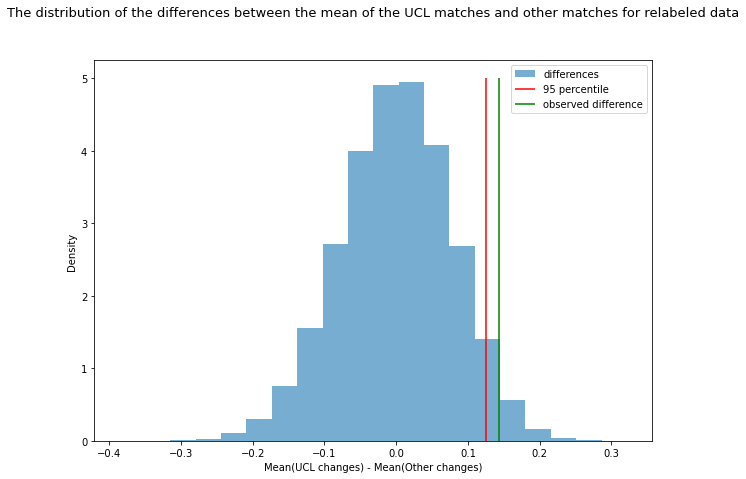

In [26]:
plt.figure(figsize=(10, 7))
plt.hist(differences, alpha = 0.6, bins = 20, density = True, label = 'differences')
plt.title("The distribution of the differences between the mean of the UCL matches and other matches for relabeled data",
         y = 1.1, fontsize = 13)
perc = np.percentile(differences, 95)
plt.vlines(perc, 0, 5, color = 'red', label = '95 percentile')
plt.vlines(mean_difference, 0, 5, color = 'green', label = 'observed difference')
plt.xlabel("Mean(UCL changes) - Mean(Other changes)")
plt.ylabel("Density")
plt.legend()

For this test, we get a p-value of $0.028$, which is again significant. 